Switch to GPU

In [1]:
#Installs for NVIDIA GeForce RTX 3080
#pip install scikit-learn
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#separately download cuda_12.3.1_546.12_windows & follow express install instructions

import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

NVIDIA GeForce RTX 3080


Dataset Class

In [2]:
from torch.utils.data import Dataset
import cv2
import os

class SegmentationDataset(Dataset):
    def __init__(self, filePaths, transforms):
        self.filePaths = filePaths
        self.transforms = transforms

    def __len__(self):
        return len(self.filePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.filePaths[idx]

        # load the image from disk, swap its channels from BGR to RGB
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # extract the label from the image path
        label = float(1 if 'dog' in imagePath else 0)

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to the image
            image = self.transforms(image)

        # return a tuple of the image and its label
        return image, label

Train/Test/Split DataLoader

In [3]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths

# Specify directories for training and testing datasets
path = 'D:/Projects/BinaryClassificationImages/train/train'
imagePaths = sorted(list(paths.list_images(path)))

# Convert the PIL Image to a PyTorch tensor
# Resize images to 224x224 for performance and standardization
transforms_list = [transforms.ToPILImage(), 
                   transforms.Resize((224, 224)),
                   transforms.ToTensor()]
transforms_composed = transforms.Compose(transforms_list)

# Use sklearn train_test_split to train on 85% of the data
split = train_test_split(imagePaths, test_size=0.15, random_state=42)
trainImages, testImages = split[:2] # First two rows are the images

# Use the dataset class defined earlier with torch.utils dataloader
train_dataset = SegmentationDataset(filePaths=trainImages, transforms=transforms_composed)
test_dataset = SegmentationDataset(filePaths=testImages, transforms=transforms_composed)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the model and its associated parameters, such as loss function, learning rate, regularization, and epoch number
model = resnet34(weights='ResNet34_Weights.DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay= 0.00001)
batchsize = 64
num_epochs = 30

# Calculate the number of batches required to finish an epoch for the training set
# Store the iteration result in the dictionary 'H'
trainSteps = len(train_dataloader) // batchsize
testSteps = len(test_dataloader) // batchsize
H = {"train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

# If cuda was set up correctly, you should be able to do this on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the device

Training Loop

Epoch [1/30] Train Loss: 0.5610, Train Accuracy: 0.5698 Test Loss: 0.6528, Test Accuracy: 0.5949
Epoch [2/30] Train Loss: 0.5426, Train Accuracy: 0.6993 Test Loss: 0.5986, Test Accuracy: 0.4923
Epoch [3/30] Train Loss: 0.5573, Train Accuracy: 0.6502 Test Loss: 0.5515, Test Accuracy: 0.6493
Epoch [4/30] Train Loss: 0.5369, Train Accuracy: 0.7545 Test Loss: 0.5468, Test Accuracy: 0.7843
Epoch [5/30] Train Loss: 0.5312, Train Accuracy: 0.7912 Test Loss: 0.5478, Test Accuracy: 0.6189
Epoch [6/30] Train Loss: 0.5294, Train Accuracy: 0.7985 Test Loss: 0.5355, Test Accuracy: 0.7877
Epoch [7/30] Train Loss: 0.5284, Train Accuracy: 0.8143 Test Loss: 0.5436, Test Accuracy: 0.7408
Epoch [8/30] Train Loss: 0.5280, Train Accuracy: 0.8102 Test Loss: 0.5619, Test Accuracy: 0.6571
Epoch [9/30] Train Loss: 0.5276, Train Accuracy: 0.8295 Test Loss: 0.5426, Test Accuracy: 0.8051
Epoch [10/30] Train Loss: 0.5276, Train Accuracy: 0.8288 Test Loss: 0.5427, Test Accuracy: 0.8464
Epoch [11/30] Train Loss: 0.5

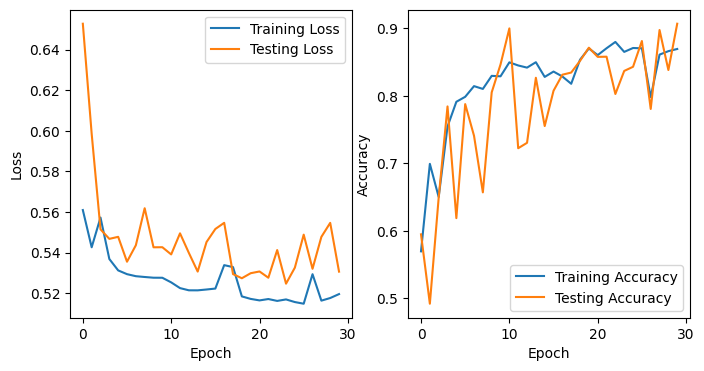

In [4]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = torch.sigmoid(model(images))

        # Calculate loss
        loss = criterion(outputs, labels.unsqueeze(1).float())
        total_train_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.sigmoid(outputs) > 0.5
        correct_train_predictions += (predicted_labels == labels.unsqueeze(1).float()).sum().item()
        total_train_samples += labels.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = correct_train_predictions / total_train_samples

    # Testing loop
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    correct_test_predictions = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = torch.sigmoid(model(images))

            # Calculate loss
            test_loss = criterion(outputs, labels.unsqueeze(1).float())
            total_test_loss += test_loss.item()

            # Calculate accuracy
            predicted_labels = torch.sigmoid(outputs) > 0.5
            correct_test_predictions += (predicted_labels == labels.unsqueeze(1).bool()).sum().item()
            total_test_samples += labels.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_accuracy = correct_test_predictions / total_test_samples

    # Update training history
    H["train_loss"].append(avg_train_loss)
    H["test_loss"].append(avg_test_loss)
    H["train_accuracy"].append(avg_train_accuracy)
    H["test_accuracy"].append(avg_test_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f} "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

# Plot the training and testing losses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(H["train_loss"], label='Training Loss')
ax1.plot(H["test_loss"], label='Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(H["train_accuracy"], label='Training Accuracy')
ax2.plot(H["test_accuracy"], label='Testing Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Save Trained Model Parameters

In [21]:
import torch
from torchvision.models import resnet34

# Save the model parameters to a file
torch.save(model.state_dict(), 'resnet_model_cats_vs_dogs.pth')

# Load the model from the saved file
model_loaded = resnet34()
model_loaded.fc = nn.Linear(model_loaded.fc.in_features, 1)
model_loaded.load_state_dict(torch.load('resnet_model_cats_vs_dogs.pth'))
model_loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Deploy Trained Model

In [23]:
import os
from torchvision import transforms
from PIL import Image
import pandas as pd

# Define the transformations
transforms_list = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]
transforms_composed = transforms.Compose(transforms_list)

# Function to get predictions for a single image
def predict_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads in BGR, convert to RGB
    input_tensor = transforms_composed(Image.fromarray(image)).unsqueeze(0)

    with torch.no_grad():
        outputs = torch.sigmoid(model(input_tensor))
    
    predicted_label = (outputs > 0.5).int().item()
    
    return predicted_label, image_path

# Folder containing the images
image_folder_path = "D:/Projects/BinaryClassificationImages/test_small"

# Get a list of image paths in the folder
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Predict for each image and store results in a dataframe
predictions = []
image_paths_list = []

for image_path in image_paths:
    prediction, path = predict_image(image_path)
    predictions.append(prediction)
    image_paths_list.append(path)

# Create a pandas dataframe
df = pd.DataFrame({
    'Image_Path': image_paths_list,
    'Prediction': predictions
})

# Save the dataframe to a CSV file
df.to_csv('predictions.csv', index=False)

Visualize Depolyed Model Outputs

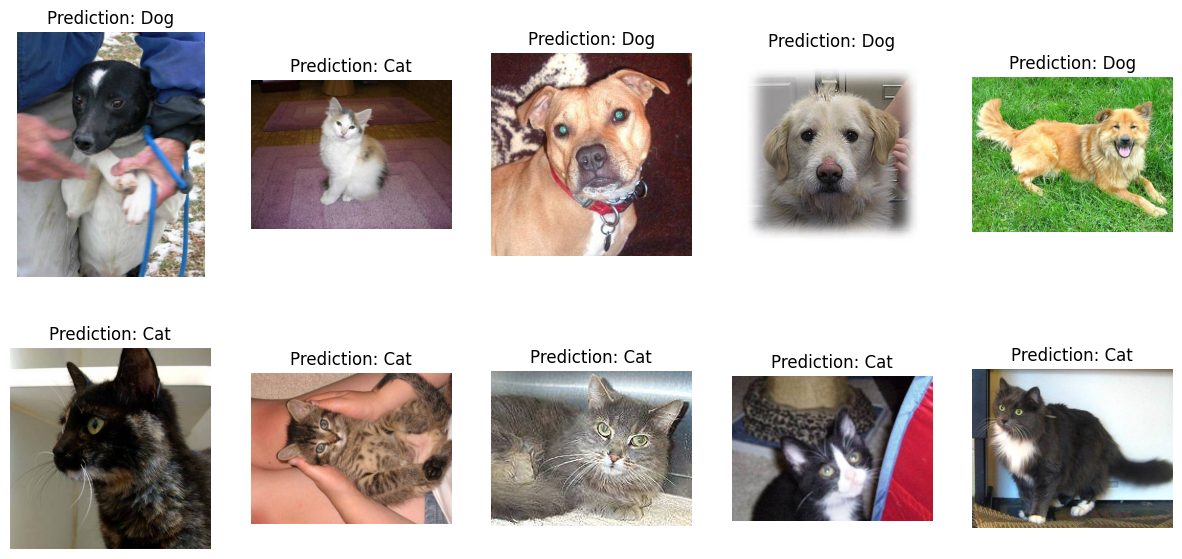

In [24]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Read the CSV file
df = pd.read_csv('predictions.csv')

# Function to get label based on the 'Prediction' column
def get_label(prediction):
    return 'Dog' if prediction == 1 else 'Cat'

# Create subplots for the first 10 entries
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    if i < len(df):
        # Read and display the image
        image_path = df.loc[i, 'Image_Path']
        image = imread(image_path)
        ax.imshow(image)
        
        # Set title with the predicted label
        prediction = df.loc[i, 'Prediction']
        label = get_label(prediction)
        ax.set_title(f'Prediction: {label}')
        
        # Remove axes for better visualization
        ax.axis('off')

plt.show()